In [2]:
import numpy as np
import rasterio
from rasterio.windows import Window
from skimage.morphology import binary_closing, square
from skimage.measure import label, regionprops

def read_raw_with_hdr(raw_path, samples, lines, bands, dtype, transform, fill_value):
    """手动读取ENVI格式的RAW文件"""
    # 根据数据规格设置参数
    dtype = np.int16  # data type=2对应ENVI的short型
    interleave = 'bsq' # 波段顺序存储
    
    # 计算数据总大小
    pixel_size = np.dtype(dtype).itemsize
    raw_size = samples * lines * bands * pixel_size
    
    # 创建内存映射
    data = np.memmap(raw_path, dtype=dtype, mode='r', 
                    shape=(bands, lines, samples),
                    order='C')  # char order=0表示大端序
    
    # 转换为numpy数组并处理填充值
    data = np.where(data == fill_value, np.nan, data).astype(np.float32)
    
    # 创建虚拟DatasetReader对象
    profile = {
        'driver': 'ENVI',
        'width': samples,
        'height': lines,
        'count': bands,
        'dtype': dtype,
        'transform': transform,
        'crs': 'EPSG:4326',
        'nodata': np.nan
    }
    return data, profile

def extract_glacier_albedo(raw_path, output_path, bounds):
    # 根据数据规格手动设置参数
    SAMPLES = 1250
    LINES = 750
    BANDS = 7
    FILL_VALUE = 32767
    SCALE_FACTOR = 10000.0
    
    # 手动构建地理变换矩阵
    # 根据数据范围：西经80°-东经105°，北纬25°-40°，分辨率0.02°
    transform = rasterio.transform.from_origin(
        west=80.0,  # 左上角经度
        north=40.0, # 左上角纬度
        xsize=0.02, # 经度分辨率
        ysize=0.02  # 纬度分辨率
    )
    
    try:
        # 读取原始数据
        data, profile = read_raw_with_hdr(
            raw_path=raw_path,
            samples=SAMPLES,
            lines=LINES,
            bands=BANDS,
            dtype=np.int16,
            transform=transform,
            fill_value=FILL_VALUE
        )
        
        # 计算目标区域的像素范围
        west, south, east, north = bounds
        window = rasterio.windows.from_bounds(
            west, south, east, north,
            transform=transform,
            height=LINES,
            width=SAMPLES
        )
        row_start = int(window.row_off)
        col_start = int(window.col_off)
        row_end = row_start + int(window.height)
        col_end = col_start + int(window.width)
        
        # 提取子区域数据
        subset = data[:, row_start:row_end, col_start:col_end]
        
        # 应用比例因子
        scaled = subset / SCALE_FACTOR
        
        # 冰川提取参数（根据新版数据说明调整）
        BSA_VIS = 0    # 第1波段：黑空可见光
        WSA_SW = 5     # 第6波段：白空短波
        QA_BAND = 6    # 第7波段：质量标识
        
        # 质量标识解码（根据文档说明）
        qa = subset[QA_BAND].astype(np.uint16)
        overall_quality = (qa & 0b0000000000000011)  # 00-01位：总体质量
        land_water = (qa & 0b0000001100000000) >> 8  # 08-09位：陆地水体标识
        
        # 创建掩膜
        mask = (
            (scaled[BSA_VIS] > 0.65) & 
            (scaled[WSA_SW] > 0.55) & 
            (overall_quality == 0) &    # 质量最优
            (land_water == 0)           # 纯陆地
        )
        
        # 形态学处理
        cleaned = binary_closing(mask, square(5))
        
        # 去除小斑块
        label_img = label(cleaned)
        regions = regionprops(label_img)
        for reg in regions:
            if reg.area < 5:
                cleaned[label_img == reg.label] = False
                
        # 保存结果
        output_profile = profile.copy()
        output_profile.update({
            'driver': 'GTiff',
            'count': 1,
            'dtype': 'uint8',
            'nodata': 0,
            'transform': rasterio.windows.transform(window, transform),
            'width': cleaned.shape[1],
            'height': cleaned.shape[0]
        })
        
        with rasterio.open(output_path, 'w', **output_profile) as dst:
            dst.write(cleaned.astype(np.uint8), 1)
            
    except Exception as e:
        print(f"处理过程中发生错误：{str(e)}")
        raise

if __name__ == "__main__":
    # 示例调用
    extract_glacier_albedo(
        raw_path="E:/himawari_tibet/ALBEDO.A2016002",  # 无扩展名的原始文件
        output_path="dongkemadi_glacier_mask.tif",
        bounds=(92.1, 33.2, 92.5, 33.6)  # 东经92.1-92.5°,北纬33.2-33.6°
    )


c:\Users\DELL\anaconda3\envs\geo_env\lib\site-packages\rasterio\windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_26608\3772118355.py:105: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  cleaned = binary_closing(mask, square(5))


In [3]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from datetime import datetime
import os
from skimage.morphology import rectangle

class AlbedoProcessor:
    def __init__(self, shp_path=None):
        # 初始化矢量掩膜
        self.geometries = self._load_shp(shp_path) if shp_path else None
        
        # 原参数配置
        self.data_dir = "E:/himawari_tibet/"
        self.output_csv = "E:/himawari_tibet/dongkemadi_albedo_2016_corrected.csv"
        self.fill_value = 32767
        self.scale_factor = 10000.0

    def _load_shp(self, shp_path):
        """加载并验证矢量掩膜"""
        if not os.path.exists(shp_path):
            raise FileNotFoundError(f"矢量文件不存在：{shp_path}")
        
        gdf = gpd.read_file(shp_path)
        if gdf.crs is None:
            raise ValueError("矢量文件缺少坐标系定义")
        return gdf.geometry

    def process_day(self, date):
        """集成矢量掩膜的单日处理"""
        try:
            raw_path = self._get_valid_path(date)
            with rasterio.open(raw_path) as src:
                # 坐标系一致性验证
                if self.geometries is not None:
                    shapes = [geom for geom in self.geometries.to_crs(src.crs)]
                else:
                    shapes = None
                
                # 矢量掩膜裁剪
                clipped, transform = mask(
                    src, 
                    shapes, 
                    crop=True, 
                    all_touched=True,  # 包含边界像元
                    nodata=self.fill_value
                )
                
                # 质量控制
                qa = clipped[6].astype(np.uint16)
                valid_mask = self._create_quality_mask(qa)
                
                # 反照率计算
                albedo = self._calculate_albedo(clipped[5], valid_mask)
                return albedo
                
        except Exception as e:
            print(f"处理{date.strftime('%Y-%m-%d')}失败：{str(e)}")
            return np.nan

    def _get_valid_path(self, date):
        """路径验证"""
        jday = date.timetuple().tm_yday
        fname = f"ALBEDO.A{date.year}{jday:03d}"
        full_path = os.path.join(self.data_dir, fname)
        
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"数据文件缺失：{fname}")
        if not os.path.exists('E:/himawari_tibet/ALBEDO.hdr'):
            raise FileNotFoundError(f"头文件缺失：{fname}.hdr")
        return full_path

    def _create_quality_mask(self, qa):
        """创建复合质量掩膜"""
        return (
            ((qa & 0x0003) == 0) )

    def _calculate_albedo(self, band_data, mask):
        """计算有效反照率"""
        scaled = band_data.astype(np.float32) / self.scale_factor
        scaled[band_data == self.fill_value] = np.nan
        
        # 形态学处理
        from skimage.morphology import binary_closing
        cleaned_mask = binary_closing(mask, rectangle(5,5))
        
        valid_albedo = scaled[cleaned_mask]
        if np.count_nonzero(~np.isnan(valid_albedo)) < 5:
            return np.nan
        return np.nanmean(valid_albedo)

    def process_year(self):
        """全年处理流程"""
        dates = pd.date_range('2016-01-01', '2016-12-31')
        results = []
        
        for date in dates:
            try:
                mean_albedo = self.process_day(date)
                results.append({
                    'Date': date.strftime('%Y-%m-%d'),
                    'Albedo_Mean': mean_albedo
                })
                # 每10天保存一次
                if date.day % 10 == 0:
                    pd.DataFrame(results).to_csv(self.output_csv, index=False)
            except Exception as e:
                print(f"严重错误：{str(e)}")
                continue
        
        df = pd.DataFrame(results)
        df.to_csv(self.output_csv, index=False)
        print(f"处理完成，有效天数：{df['Albedo_Mean'].notna().sum()}/{len(df)}")

# 使用示例
if __name__ == "__main__":
    # 使用矢量掩膜
    processor = AlbedoProcessor(shp_path="D:/CSSP/DKMD/XDKMD.shp")
    processor.process_year()


c:\Users\DELL\anaconda3\envs\geo_env\lib\site-packages\rasterio\__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


处理2016-01-01失败：Must pass either crs or epsg.
处理2016-01-02失败：Cannot invert degenerate transform
处理2016-01-03失败：Cannot invert degenerate transform
处理2016-01-04失败：Cannot invert degenerate transform
处理2016-01-05失败：Cannot invert degenerate transform
处理2016-01-06失败：Cannot invert degenerate transform
处理2016-01-07失败：Cannot invert degenerate transform
处理2016-01-08失败：Cannot invert degenerate transform
处理2016-01-09失败：Cannot invert degenerate transform
处理2016-01-10失败：Cannot invert degenerate transform
处理2016-01-11失败：Cannot invert degenerate transform
处理2016-01-12失败：Cannot invert degenerate transform
处理2016-01-13失败：Cannot invert degenerate transform
处理2016-01-14失败：Cannot invert degenerate transform
处理2016-01-15失败：Cannot invert degenerate transform
处理2016-01-16失败：Cannot invert degenerate transform
处理2016-01-17失败：Cannot invert degenerate transform
处理2016-01-18失败：Cannot invert degenerate transform
处理2016-01-19失败：Cannot invert degenerate transform
处理2016-01-20失败：Cannot invert degenerate transform
处理201

已读取实测数据，共366条记录
已读取模拟数据，形状: (366, 39)
模拟数据年份范围: 1979-2017
找到2016年数据，列索引: 37

统计指标:
相关系数: -0.2381 (p值: 0.0000)
均方根误差: 0.0998
决定系数(R2): -0.4123
平均偏差: -0.0245


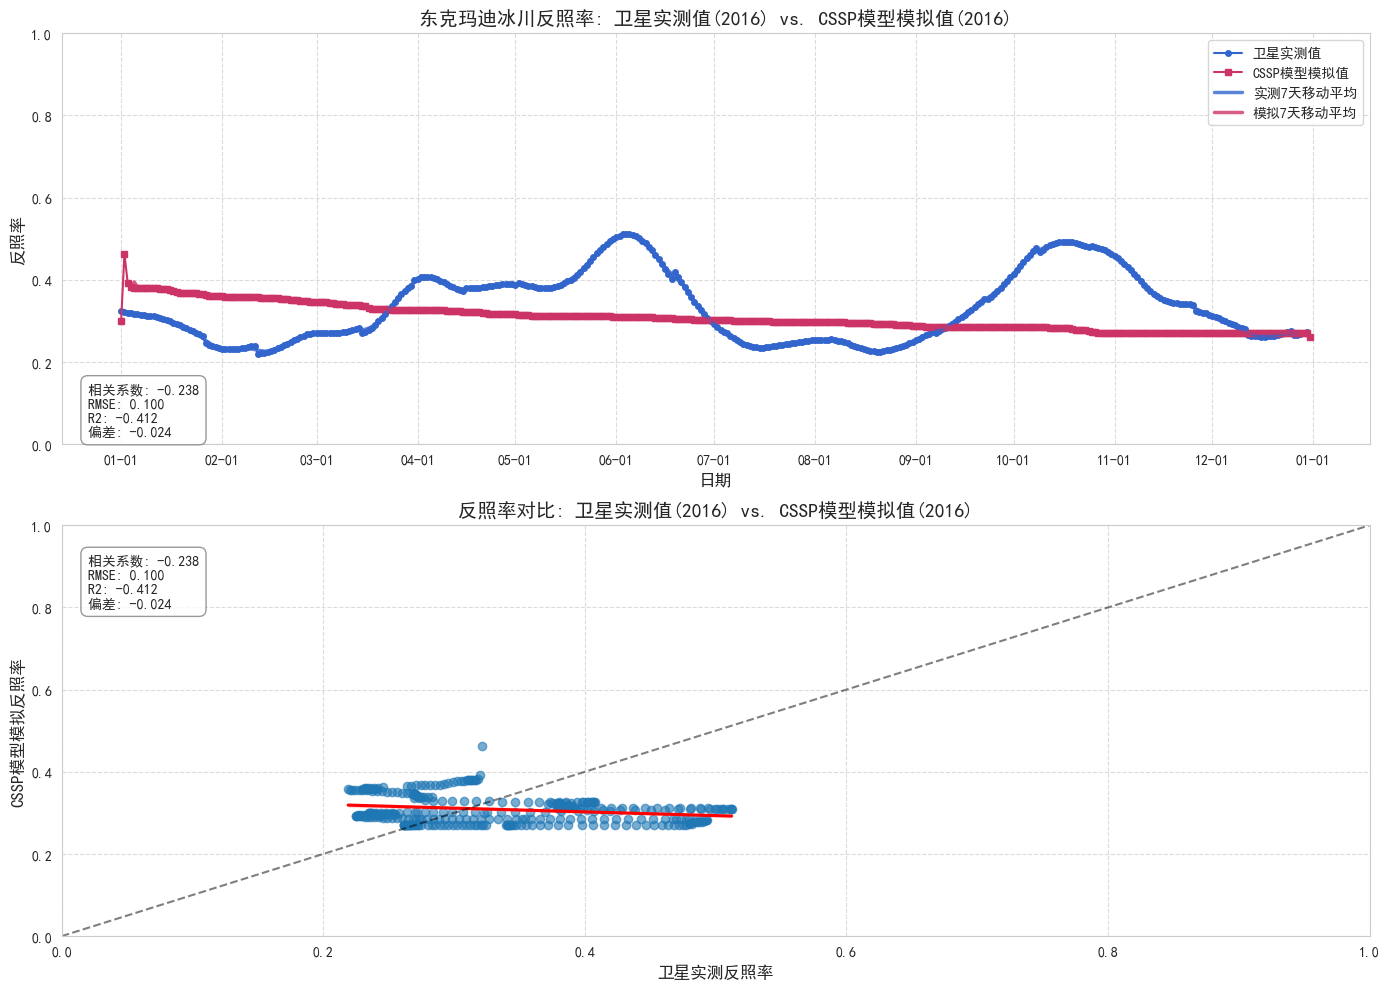


月度统计对比:
   Date Albedo_Mean                 Albedo_Simulated                
               mean       std count             mean       std count
0     1    0.290225  0.028314    31         0.373373  0.022726    31
1     2    0.239789  0.014921    29         0.354460  0.004064    29
2     3    0.303576  0.042126    31         0.334634  0.007389    31
3     4    0.388907  0.010550    30         0.321571  0.003563    30
4     5    0.414495  0.039987    31         0.312125  0.001071    31
5     6    0.428273  0.071425    30         0.306278  0.002777    30
6     7    0.249665  0.015107    31         0.299407  0.001261    31
7     8    0.240235  0.010695    31         0.294069  0.003158    31
8     9    0.317877  0.046074    30         0.285067  0.000816    30
9    10    0.473057  0.020449    31         0.279994  0.005143    31
10   11    0.370784  0.044150    30         0.271081  0.000068    30
11   12    0.277126  0.016190    30         0.270055  0.001709    31


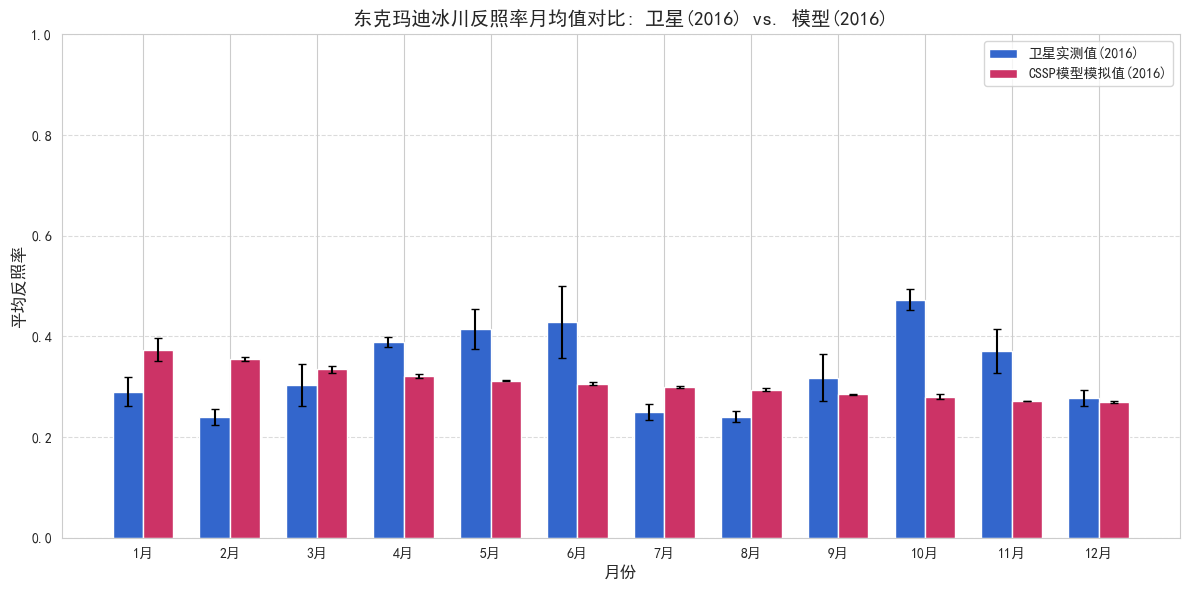

In [15]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import os
from rasterio.windows import Window
import rasterio

# 定义AlbedoProcessor类
class AlbedoProcessor:
    def __init__(self):
        # 数据参数配置
        self.data_dir = "E:/himawari_tibet/"
        self.output_csv = "dongkemadi_albedo_2016_corrected.csv"
        self.glacier_bounds = (92.0, 33.0, 92.17, 33.2)  
        
        # 数据规格参数 (根据文件说明)
        self.samples = 1250  # 列数
        self.lines = 750     # 行数
        self.bands = 7       # 波段数
        self.fill_value = 32767
        self.scale_factor = 10000.0
        self.dtype = np.int16
        
        # 地理参考参数
        self.west = 80.0
        self.north = 40.0
        self.res = 0.02
        
        # 波段索引 (基于0的索引)
        self.BSA_shortwave_idx = 2  # 第3波段 - 短波黑空反照率
        self.WSA_shortwave_idx = 5  # 第6波段 - 短波白空反照率
        self.qa_idx = 6            # 第7波段 - 质量标识

    def generate_dates(self):
        """生成有效日期列表（处理闰年问题）"""
        try:
            return pd.date_range('2016-01-01', '2016-12-31')
        except Exception:
            return pd.date_range('2016-01-01', '2016-12-30')

    def get_raw_path(self, date):
        """生成带验证的文件路径"""
        jday = date.timetuple().tm_yday
        fname = f"ALBEDO.A{date.year}{jday:03d}"  # 添加.raw后缀
        raw_path = os.path.join(self.data_dir, fname)
        hdr_path = os.path.join(self.data_dir, 'ALBEDO.hdr')  # 使用统一的头文件
        
        # 验证文件存在性
        if not os.path.exists(raw_path):
            print(f"文件缺失：{fname}")
            return None
        if not os.path.exists(hdr_path):
            print(f"头文件缺失：ALBEDO.hdr")
            return None
        return raw_path
    
    def calculate_window(self):
        """精确计算冰川区域窗口"""
        west, south, east, north = self.glacier_bounds
        
        # 列计算（经度方向）
        col_start = int((west - self.west) / self.res)
        col_end = int((east - self.west) / self.res)
        
        # 行计算（纬度方向，注意反向）
        row_start = int((self.north - north) / self.res)
        row_end = int((self.north - south) / self.res)
        print(col_start,col_end,row_start,row_end)
        
        return Window(
            col_off=col_start,
            row_off=row_start,
            width=col_end - col_start,
            height=row_end - row_start
        )

    def parse_quality_flag(self, qa_value):
        """解析质量标识位"""
        # 转换为16位二进制
        binary = format(qa_value, '016b')
        
        # 提取各个标识位
        quality = int(binary[0:2], 2)           # 00-01位 总体质量
        surface_type = int(binary[2:4], 2)      # 02-03位 地表类型
        change_state = int(binary[4:5], 2)      # 04位 地表状态变化
        observations = int(binary[5:8], 2)      # 05-07位 观测次数
        sensor_source = int(binary[8:9], 2)     # 08位 卫星数据源
        land_water = int(binary[9:11], 2)       # 09-10位 陆地水体标识
        
        return {
            'quality': quality,
            'surface_type': surface_type,
            'change_state': change_state,
            'observations': observations,
            'sensor_source': sensor_source,
            'land_water': land_water
        }

    def process_day(self, date):
        """处理单日数据"""
        try:
            # 获取有效路径
            raw_path = self.get_raw_path(date)
            if raw_path is None:
                return np.nan
            
            # 预计算窗口
            window = self.calculate_window()
            
            # 读取数据（带异常捕获）
            try:
                with rasterio.open(raw_path) as src:
                    data = src.read(window=window)
            except rasterio.errors.RasterioIOError:
                print(f"文件损坏：{os.path.basename(raw_path)}")
                return np.nan

            # 数据验证
            if data.shape != (self.bands, window.height, window.width):
                print(f"数据维度异常：{data.shape} vs expected {(self.bands, window.height, window.width)}")
                return np.nan

            # 数据转换
            scaled = data.astype(np.float32) / self.scale_factor
            scaled[data == self.fill_value] = np.nan

            # 质量掩膜（根据标识定义）
            qa = data[self.qa_idx].astype(np.uint16)  # 第7波段质量标识
            
            # 正确提取地表类型为冰雪的像素
            quality_mask = (
                ((qa & 0x0003) == 0)          # 00-01位: 总体质量好 (值为0)
            )
            
            # 提取有效数据
            albedo_band = scaled[self.WSA_shortwave_idx]  # 第6波段，短波白空反照率
            valid_albedo = albedo_band[quality_mask & ~np.isnan(albedo_band)]
            
            # 统计计算
            if valid_albedo.size < 5:  # 至少需要5个有效像素
                print(f"{date.strftime('%Y-%m-%d')} 有效冰雪像素不足：{valid_albedo.size}")
                return np.nan
            
            # 计算统计量
            mean_albedo = np.nanmean(valid_albedo)
            
            # 调试输出
            print(f"{date.strftime('%Y-%m-%d')} 冰雪像素数量: {valid_albedo.size}, 平均反照率: {mean_albedo:.3f}")
            
            return mean_albedo
            
        except Exception as e:
            print(f"处理{date.strftime('%Y-%m-%d')}时发生未捕获错误：{str(e)}")
            return np.nan

    def process_year(self):
        """处理全年数据"""
        df = pd.DataFrame(columns=['Date', 'Albedo_Mean'])
        dates = self.generate_dates()
        
        for date in dates:
            mean_albedo = self.process_day(date)
            new_data = pd.DataFrame({
                'Date': [date.strftime('%Y-%m-%d')],
                'Albedo_Mean': [mean_albedo]
            })
            df = pd.concat([df, new_data], ignore_index=True)
            
            # 进度输出
            if date.day == 1:
                print(f"已处理至 {date.strftime('%Y-%m')}...")
        
        # 数据清洗
        df['Albedo_Mean'] = df['Albedo_Mean'].clip(0, 1)  # 确保反照率在0-1范围内
        
        # 保存结果
        df.to_csv(self.output_csv, index=False)
        valid_ratio = df['Albedo_Mean'].notna().mean()
        print(f"处理完成，共 {len(df)} 天，有效数据 {int(valid_ratio * len(df))} 天，占比 {valid_ratio:.1%}")
        
        return df

# 您已经定义的函数
def compare_observed_simulated_albedo():
    # 函数内容...如您提供的代码
    """比较卫星实测反照率与CSSP模拟值"""
    # 读取实测反照率数据
    processor = AlbedoProcessor()
    observed_file = processor.output_csv
    
    try:
        observed_df = pd.read_csv(observed_file)
        observed_df['Date'] = pd.to_datetime(observed_df['Date'])
        print(f"已读取实测数据，共{len(observed_df)}条记录")
    except FileNotFoundError:
        print(f"未找到实测数据文件: {observed_file}")
        print("正在处理实测数据...")
        observed_df = processor.process_year()
    
    # 读取模拟数据
    sim_file = r'D:\CSSP\out_data\DKMD\CSSPsurface_FEVPA_DKMD_v4.3.csv'
 
    # 读取CSV
    sim_raw = pd.read_csv(sim_file)
    sim = np.array(sim_raw)
    print(f"已读取模拟数据，形状: {sim.shape}")
    
    # 确定列对应的年份 - 假设列按年份顺序排列
    # 假设从1979年开始，连续39年
    start_year = 1979
    years = list(range(start_year, start_year + sim.shape[1]))
    print(f"模拟数据年份范围: {years[0]}-{years[-1]}")
    
    # 检查2016年是否在范围内
    if 2016 in years:
        year_idx = years.index(2016)
        print(f"找到2016年数据，列索引: {year_idx}")
    else:
        print("模拟数据中不包含2016年")
        # 使用最近年份数据
        year_idx = -1  # 使用最后一年
        print(f"使用{years[year_idx]}年数据作为替代")
        
    # 创建2016年每天的模拟值数据框
    # 注意：数组索引从0开始
    sim_2016 = pd.DataFrame()
    sim_2016['Date'] = pd.date_range('2016-01-01', '2016-12-31')
    sim_2016['DOY'] = sim_2016['Date'].dt.dayofyear
    
    # 提取对应年份的数据列
    sim_albedo = sim[:, year_idx]
    
    # 对应每天的DOY到模拟值
    sim_2016['Albedo_Simulated'] = sim_2016['DOY'].apply(
        lambda d: sim_albedo[min(d-1, len(sim_albedo)-1)] if d <= len(sim_albedo) else np.nan
    )
    
    # 合并数据集
    merged_df = pd.merge(observed_df, sim_2016, on='Date', how='left')
    
    # 计算统计指标
    valid_mask = ~np.isnan(merged_df['Albedo_Mean']) & ~np.isnan(merged_df['Albedo_Simulated'])
    if sum(valid_mask) > 0:
        obs = merged_df.loc[valid_mask, 'Albedo_Mean']
        sim_vals = merged_df.loc[valid_mask, 'Albedo_Simulated']
        
        correlation, p_value = stats.pearsonr(obs, sim_vals)
        rmse = np.sqrt(mean_squared_error(obs, sim_vals))
        r2 = r2_score(obs, sim_vals)
        mean_bias = np.mean(sim_vals - obs)
        
        print(f"\n统计指标:")
        print(f"相关系数: {correlation:.4f} (p值: {p_value:.4f})")
        print(f"均方根误差: {rmse:.4f}")
        print(f"决定系数(R2): {r2:.4f}")
        print(f"平均偏差: {mean_bias:.4f}")
        
        # 绘制对比图
        plt.figure(figsize=(14, 10))
        
        # 子图1: 时间序列对比
        plt.subplot(2, 1, 1)
        plt.plot(merged_df['Date'], merged_df['Albedo_Mean'], 'o-', color='#3366CC', 
                markersize=4, linewidth=1.5, label='卫星实测值')
        plt.plot(merged_df['Date'], merged_df['Albedo_Simulated'], 's-', color='#CC3366', 
                markersize=4, linewidth=1.5, label='CSSP模型模拟值')
        
        # 添加移动平均线
        window_size = 7
        merged_df['Obs_MA7'] = merged_df['Albedo_Mean'].rolling(window=window_size, center=True).mean()
        merged_df['Sim_MA7'] = merged_df['Albedo_Simulated'].rolling(window=window_size, center=True).mean()
        
        plt.plot(merged_df['Date'], merged_df['Obs_MA7'], '-', color='#3366CC', 
                linewidth=2.5, alpha=0.8, label=f'实测{window_size}天移动平均')
        plt.plot(merged_df['Date'], merged_df['Sim_MA7'], '-', color='#CC3366', 
                linewidth=2.5, alpha=0.8, label=f'模拟{window_size}天移动平均')
        
        # 设置图表样式
        use_year = years[year_idx]
        plt.title(f'东克玛迪冰川反照率: 卫星实测值(2016) vs. CSSP模型模拟值({use_year})', fontsize=14)
        plt.xlabel('日期', fontsize=12)
        plt.ylabel('反照率', fontsize=12)
        plt.ylim(0, 1)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='upper right')
        
        # 添加统计指标文本框
        stats_text = f"相关系数: {correlation:.3f}\nRMSE: {rmse:.3f}\nR2: {r2:.3f}\n偏差: {mean_bias:.3f}"
        plt.annotate(stats_text, xy=(0.02, 0.02), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
                    fontsize=10)
        
        # 子图2: 散点图与回归线
        plt.subplot(2, 1, 2)
        sns.regplot(x=obs, y=sim_vals, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # 1:1线
        plt.title(f'反照率对比: 卫星实测值(2016) vs. CSSP模型模拟值({use_year})', fontsize=14)
        plt.xlabel('卫星实测反照率', fontsize=12)
        plt.ylabel('CSSP模型模拟反照率', fontsize=12)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 添加统计指标文本框
        plt.annotate(stats_text, xy=(0.02, 0.80), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
                    fontsize=10)
        
        plt.tight_layout()
        plt.savefig('albedo_comparison_observed_vs_simulated.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 分月统计对比
        monthly_stats = merged_df.groupby(merged_df['Date'].dt.month).agg({
            'Albedo_Mean': ['mean', 'std', 'count'],
            'Albedo_Simulated': ['mean', 'std', 'count']
        }).reset_index()
        
        print("\n月度统计对比:")
        print(monthly_stats)
        
        # 绘制月度对比图
        plt.figure(figsize=(12, 6))
        
        # 绘制条形图
        months = monthly_stats['Date']
        x = np.arange(len(months))
        width = 0.35
        
        obs_means = monthly_stats[('Albedo_Mean', 'mean')]
        sim_means = monthly_stats[('Albedo_Simulated', 'mean')]
        
        plt.bar(x - width/2, obs_means, width, label=f'卫星实测值(2016)', color='#3366CC')
        plt.bar(x + width/2, sim_means, width, label=f'CSSP模型模拟值({use_year})', color='#CC3366')
        
        # 添加误差棒
        obs_std = monthly_stats[('Albedo_Mean', 'std')]
        sim_std = monthly_stats[('Albedo_Simulated', 'std')]
        
        plt.errorbar(x - width/2, obs_means, yerr=obs_std, fmt='none', ecolor='black', capsize=3)
        plt.errorbar(x + width/2, sim_means, yerr=sim_std, fmt='none', ecolor='black', capsize=3)
        
        # 设置图表样式
        plt.title(f'东克玛迪冰川反照率月均值对比: 卫星(2016) vs. 模型({use_year})', fontsize=14)
        plt.xlabel('月份', fontsize=12)
        plt.ylabel('平均反照率', fontsize=12)
        plt.ylim(0, 1)
        plt.xticks(x, [f"{m}月" for m in months])
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('monthly_albedo_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    else:
        print("没有足够的有效匹配数据进行对比分析")

# 运行函数
if __name__ == "__main__":
    # 设置风格
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    # 执行比较函数
    compare_observed_simulated_albedo()

已读取模拟数据，形状: (366, 39)
模拟数据年份范围: 1979-2017


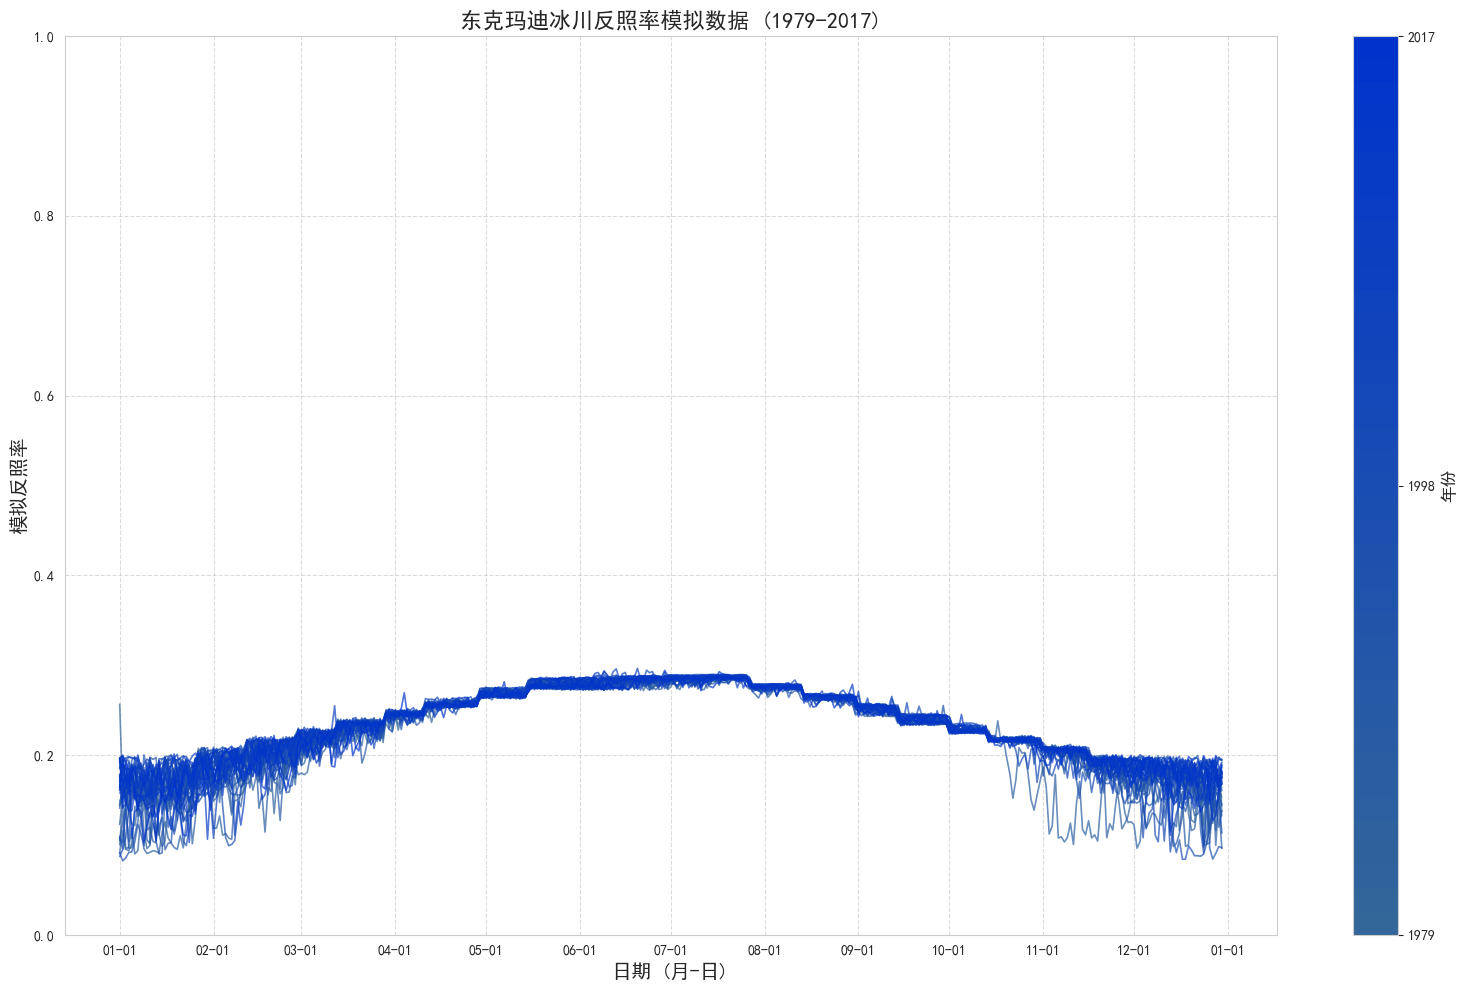

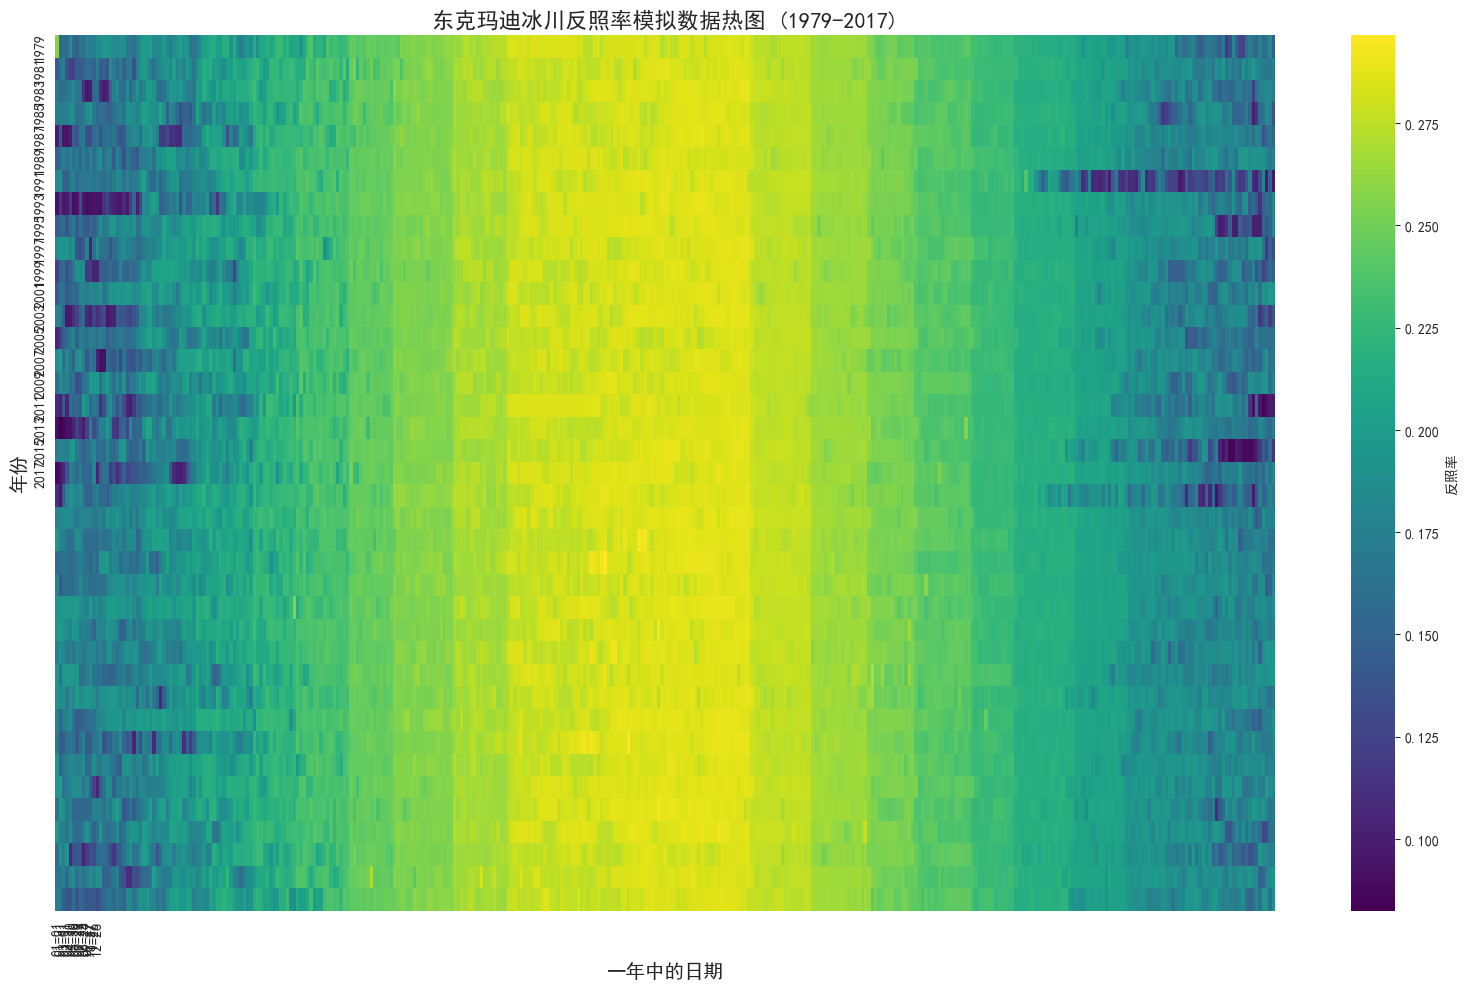

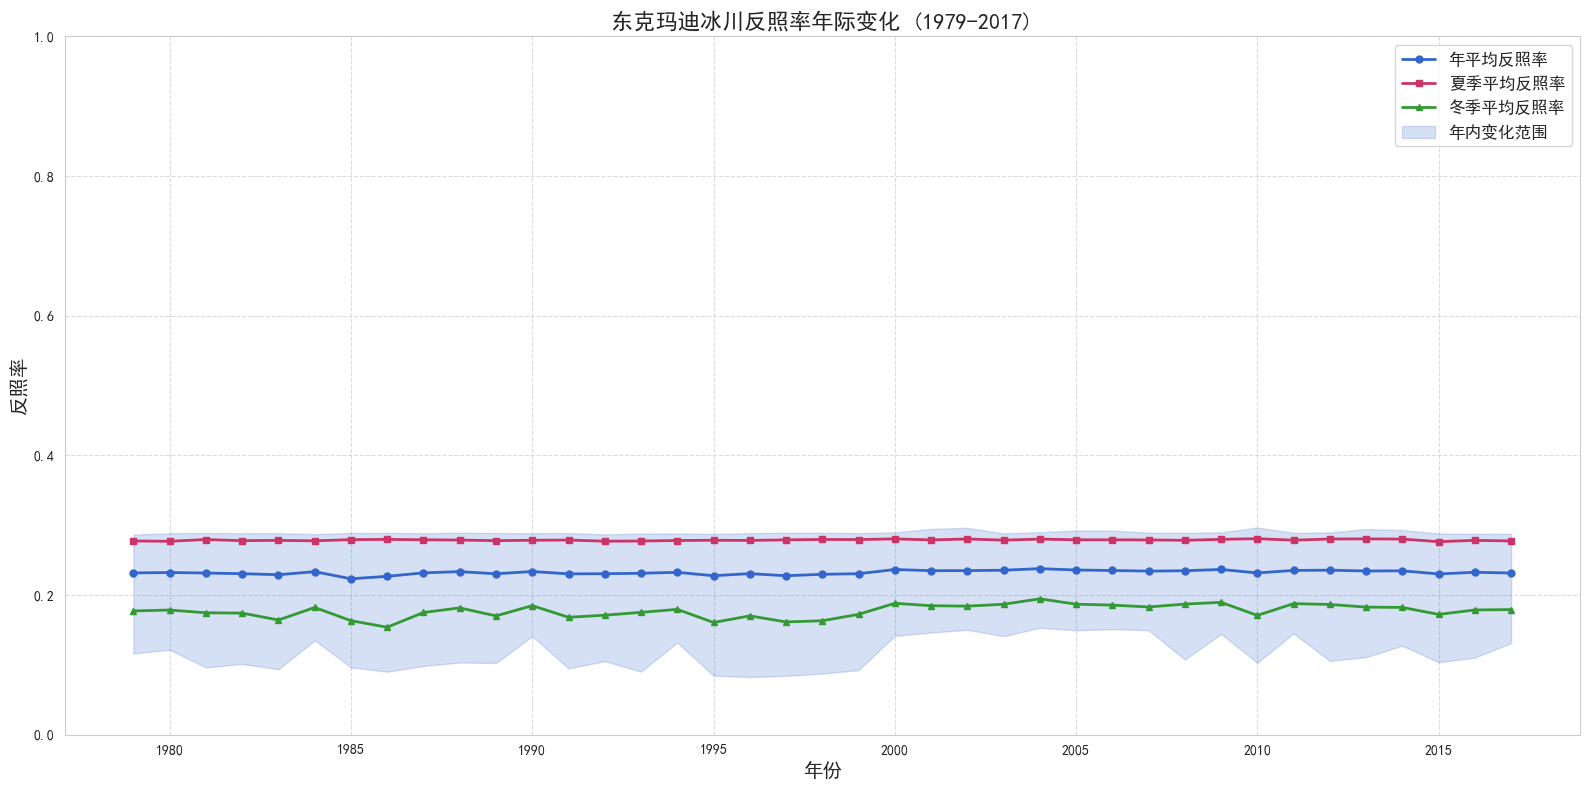

[0.23150101 0.2321182  0.23138052 0.23040869 0.22894724 0.23333429
 0.22312792 0.22665411 0.23159519 0.23336674 0.23031188 0.23352032
 0.23018687 0.2303667  0.23102775 0.23235702 0.22751679 0.23051595
 0.22747221 0.22954997 0.23038358 0.23641261 0.23471309 0.23480138
 0.23537839 0.23764674 0.23569538 0.23499646 0.23413191 0.23460658
 0.23648282 0.23148603 0.23509282 0.23546766 0.23427551 0.23451634
 0.23007559 0.23244847 0.23139921]


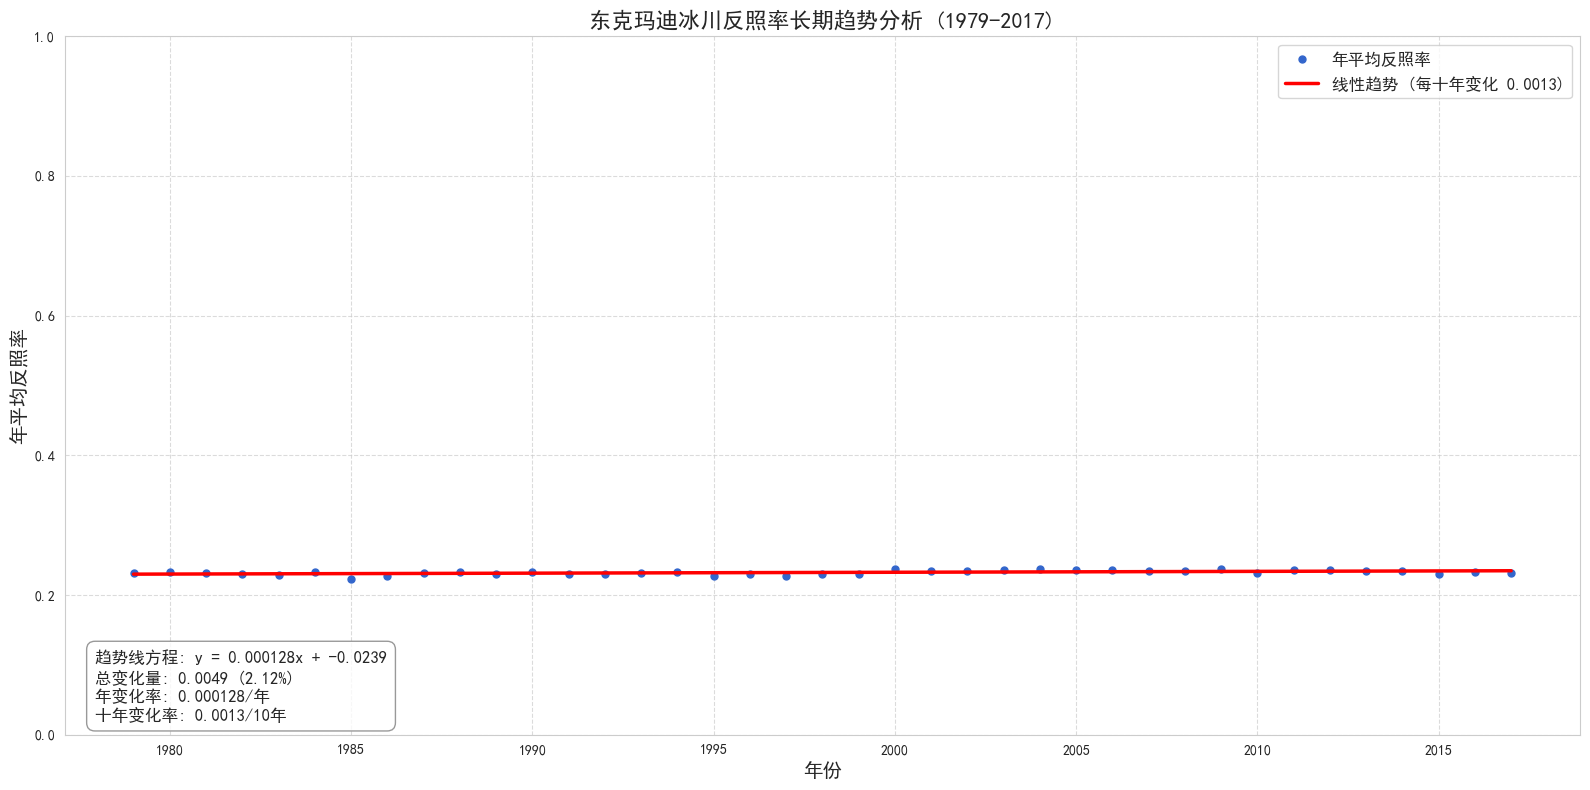

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import os

def plot_all_simulated_albedo_years():
    """绘制所有年份的模拟反照率数据时间序列图"""
    # 读取模拟数据
    sim_file = r'D:\CSSP\out_data\DKMD\CSSPsurface_FEVPG_GLACIER_DKMD_v5.4.csv'
    
    # 检查文件是否存在
    if not os.path.exists(sim_file):
        print(f"错误：找不到模拟数据文件: {sim_file}")
        return
 
    # 读取CSV
    try:
        sim_raw = pd.read_csv(sim_file)
        sim = np.array(sim_raw)
        print(f"已读取模拟数据，形状: {sim.shape}")
    except Exception as e:
        print(f"读取数据时出错: {str(e)}")
        return
    
    # 确定列对应的年份 - 假设列按年份顺序排列
    # 假设从1979年开始，连续39年
    start_year = 1979
    end_year = start_year + sim.shape[1] - 1
    years = list(range(start_year, start_year + sim.shape[1]))
    print(f"模拟数据年份范围: {years[0]}-{years[-1]}")
    
    # ---------- 1. 绘制所有年份的线图 ----------
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # 创建自定义渐变色映射，从浅蓝到深蓝
    colors = [(0.2, 0.4, 0.6), (0, 0.2, 0.8)]  # 从浅蓝到深蓝
    cmap_name = 'blue_gradient'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(years))
    
    # 创建日期序列（忽略闰年，使用标准的365天）
    days = list(range(1, 366))
    
    # 创建一个标准年的日期对象，用于更好的x轴显示
    date_range = pd.date_range(start='2016-01-01', periods=365)
    
    # 绘制每一年的数据
    for i, year in enumerate(years):
        # 获取该年的反照率数据
        year_albedo = sim[:, i]
        
        # 确保数据长度和天数匹配
        if len(year_albedo) < len(days):
            # 如果数据少于365天，需要补全
            padded_albedo = np.pad(year_albedo, (0, len(days) - len(year_albedo)), 'constant', constant_values=np.nan)
            ax.plot(date_range, padded_albedo, '-', color=cm(i/len(years)), 
                     linewidth=1.2, alpha=0.7)
        else:
            # 如果数据足够或过多，截取365天
            ax.plot(date_range, year_albedo[:len(days)], '-', color=cm(i/len(years)), 
                     linewidth=1.2, alpha=0.7)
    
    # 设置图表样式
    ax.set_title(f'东克玛迪冰川反照率模拟数据 ({start_year}-{end_year})', fontsize=16)
    ax.set_xlabel('日期 (月-日)', fontsize=14)
    ax.set_ylabel('模拟反照率', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 优化x轴标签
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    # 添加颜色图例，显示年份过渡 - 这里是关键修复
    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min(years), max(years)))
    sm.set_array([])  # 空数组，因为我们已经设置了norm
    cbar = fig.colorbar(sm, ax=ax)  # 明确指定ax参数
    cbar.set_label('年份', fontsize=12)
    cbar.set_ticks([start_year, start_year + (end_year-start_year)//2, end_year])
    
    plt.tight_layout()
    plt.savefig('all_years_albedo_simulation_lines.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ---------- 2. 绘制热图 ----------
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # 准备热图数据，可能需要转置以便年份在y轴
    heatmap_data = sim[:365, :].T  # 取前365天，转置后行是年份，列是日期
    
    # 创建日期标签
    date_labels = [date.strftime('%m-%d') for date in pd.date_range(start='2016-01-01', periods=365, freq='D')]
    selected_dates = date_labels[::30]  # 每30天选择一个标签
    selected_indices = list(range(0, 365, 30))
    
    # 创建年份标签
    year_step = max(1, len(years) // 15)  # 控制显示的年份数量
    selected_years = years[::year_step]
    selected_year_indices = list(range(0, len(years), year_step))
    
    # 绘制热图
    sns.heatmap(heatmap_data, cmap='viridis', ax=ax,
                xticklabels=selected_indices, yticklabels=selected_year_indices,
                cbar_kws={'label': '反照率'})
    
    # 设置标签
    ax.set_title('东克玛迪冰川反照率模拟数据热图 ({}-{})'.format(start_year, end_year), fontsize=16)
    ax.set_xlabel('一年中的日期', fontsize=14)
    ax.set_ylabel('年份', fontsize=14)
    
    # 设置x轴标签为日期格式
    ax.set_xticklabels(selected_dates)
    # 设置y轴标签为年份
    ax.set_yticklabels(selected_years)
    
    plt.tight_layout()
    plt.savefig('albedo_simulation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ---------- 3. 绘制年际变化图 ----------
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # 计算各年份的统计数据
    annual_stats = pd.DataFrame(index=years)
    annual_stats['mean'] = [np.nanmean(sim[:, i]) for i in range(sim.shape[1])]
    annual_stats['max'] = [np.nanmax(sim[:, i]) for i in range(sim.shape[1])]
    annual_stats['min'] = [np.nanmin(sim[:, i]) for i in range(sim.shape[1])]
    
    # 计算季节性统计（夏季定义为6-8月，冬季为12-2月）
    summer_indices = list(range(151, 243))  # 6月1日至8月31日（大约第151-243天）
    winter_indices = list(range(0, 59)) + list(range(334, 365))  # 12月1日至2月28日
    
    annual_stats['summer_mean'] = [np.nanmean(sim[summer_indices, i]) for i in range(sim.shape[1])]
    annual_stats['winter_mean'] = [np.nanmean(sim[winter_indices, i]) for i in range(sim.shape[1])]
    
    # 绘制年际变化图
    ax.plot(annual_stats.index, annual_stats['mean'], 'o-', color='#3366CC', 
             markersize=5, linewidth=2, label='年平均反照率')
    
    # 绘制季节均值
    ax.plot(annual_stats.index, annual_stats['summer_mean'], 's-', color='#CC3366', 
             markersize=5, linewidth=2, label='夏季平均反照率')
    ax.plot(annual_stats.index, annual_stats['winter_mean'], '^-', color='#339933', 
             markersize=5, linewidth=2, label='冬季平均反照率')
    
    # 绘制范围区域
    ax.fill_between(annual_stats.index, annual_stats['min'], annual_stats['max'], 
                     color='#3366CC', alpha=0.2, label='年内变化范围')
    
    # 设置图表样式
    ax.set_title('东克玛迪冰川反照率年际变化 ({}-{})'.format(start_year, end_year), fontsize=16)
    ax.set_xlabel('年份', fontsize=14)
    ax.set_ylabel('反照率', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)
    
    # 为年份轴设置合适的刻度
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    plt.tight_layout()
    plt.savefig('albedo_annual_variation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ---------- 4. 添加趋势分析图 ----------
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # 绘制年平均反照率并添加线性趋势线
    x = np.array(annual_stats.index)
    y = annual_stats['mean'].values
    
    # 线性拟合
    mask = ~np.isnan(y)
    if np.sum(mask) > 2:  # 确保有足够的数据点进行拟合
        z = np.polyfit(x[mask], y[mask], 1)
        p = np.poly1d(z)
        trend_line = p(x)
        
        # 计算趋势和变化率
        total_change = p(x[-1]) - p(x[0])
        change_rate = z[0] * 10  # 每十年变化率
        
        # 绘制数据点和趋势线
        ax.plot(x, y, 'o', color='#3366CC', markersize=5, label='年平均反照率')
        print(y)
        ax.plot(x, trend_line, '-', color='red', linewidth=2.5, 
                label=f'线性趋势 (每十年变化 {change_rate:.4f})')
        
        # 添加趋势信息文本
        trend_text = f"趋势线方程: y = {z[0]:.6f}x + {z[1]:.4f}\n"
        trend_text += f"总变化量: {total_change:.4f} ({total_change/p(x[0])*100:.2f}%)\n"
        trend_text += f"年变化率: {z[0]:.6f}/年\n"
        trend_text += f"十年变化率: {change_rate:.4f}/10年"
        
        ax.text(0.02, 0.02, trend_text, transform=ax.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    # 设置图表样式
    ax.set_title('东克玛迪冰川反照率长期趋势分析 ({}-{})'.format(start_year, end_year), fontsize=16)
    ax.set_xlabel('年份', fontsize=14)
    ax.set_ylabel('年平均反照率', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)
    
    # 为年份轴设置合适的刻度
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    plt.tight_layout()
    plt.savefig('albedo_trend_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # 设置风格
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    # 执行绘图函数
    plot_all_simulated_albedo_years()

In [ ]:
# 读取模拟数据
sim_file = r'D:\CSSP\out_data\DKMD\CSSPsurface_FEVPA_DKMD_v4.3.csv'

# 读取CSV
sim_raw = pd.read_csv(sim_file)
sim = np.array(sim_raw)
print(f"已读取模拟数据，形状: {sim.shape}")

# 确定列对应的年份 - 假设列按年份顺序排列
# 假设从1979年开始，连续39年
start_year = 1979
years = list(range(start_year, start_year + sim.shape[1]))
print(f"模拟数据年份范围: {years[0]}-{years[-1]}")

# 检查2016年是否在范围内
if 2016 in years:
    year_idx = years.index(2016)
    print(f"找到2016年数据，列索引: {year_idx}")
else:
    print("模拟数据中不包含2016年")
    # 使用最近年份数据
    year_idx = -1  # 使用最后一年
    print(f"使用{years[year_idx]}年数据作为替代")
    
# 创建2016年每天的模拟值数据框
# 注意：数组索引从0开始
sim_2016 = pd.DataFrame()
sim_2016['Date'] = pd.date_range('2016-01-01', '2016-12-31')
sim_2016['DOY'] = sim_2016['Date'].dt.dayofyear

# 提取对应年份的数据列
sim_albedo = sim[:, year_idx]
t_dew = (sim_albedo - 0.6487)/0.008
print(t_dew)

已读取实测数据，共366条记录
已读取模拟数据，形状: (366, 39)
模拟数据年份范围: 1979-2017
找到2016年数据，列索引: 37
正在进行模拟数据季节性调整...


c:\Users\DELL\anaconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\anaconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\DELL\anaconda3\envs\geo_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


模拟数据季节性调整完成
合并后的有效数据点: 366条

调整后模拟数据统计指标:
相关系数: 0.9601 (p值: 0.0000)
均方根误差(RMSE): 0.0235
平均绝对误差(MAE): 0.0187
决定系数(R²): 0.9217
平均偏差: 0.0002

原始模拟数据统计指标:
相关系数: -0.2381 (p值: 0.0000)
均方根误差(RMSE): 0.0998
平均绝对误差(MAE): 0.0831
决定系数(R²): -0.4123
平均偏差: -0.0245


C:\Users\DELL\AppData\Local\Temp\ipykernel_38152\958050669.py:468: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.savefig('albedo_comparison_observed_vs_all_models.png', dpi=300, bbox_inches='tight')
c:\Users\DELL\anaconda3\envs\geo_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


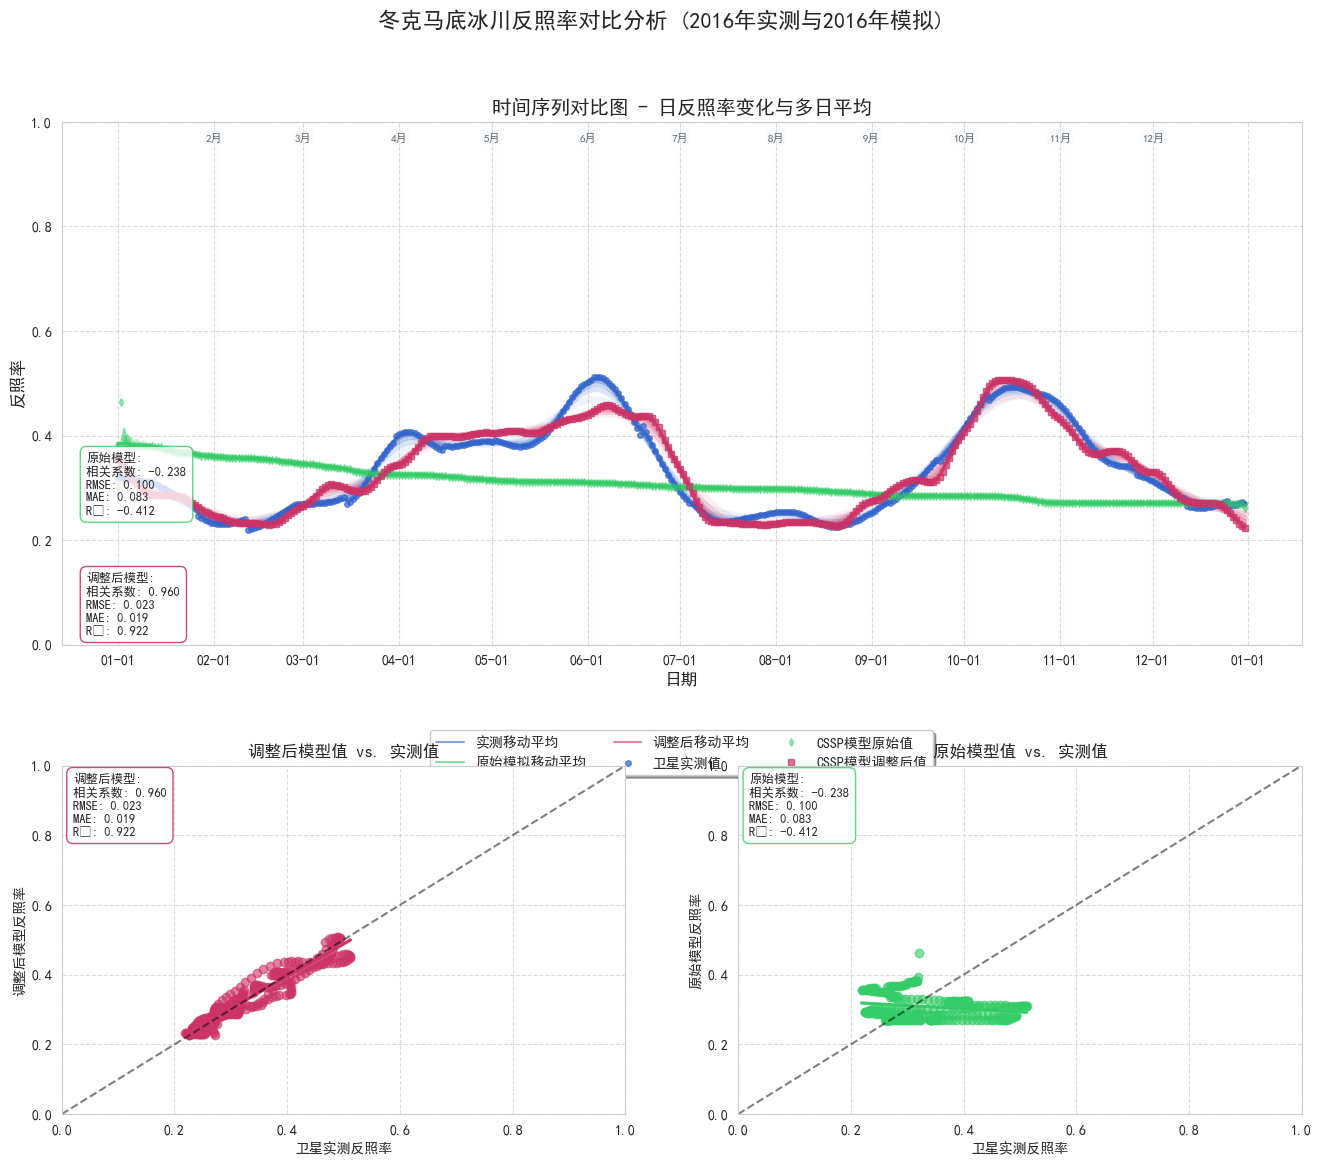


========== 月度分析过渡 ==========
下面展示按月份比较模型与观测值的结果，以更宏观的视角理解数据


月度统计对比:
   Date Albedo_Mean                 Albedo_Simulated                  \
               mean       std count             mean       std count   
0     1    0.290225  0.028314    31         0.291132  0.028024    31   
1     2    0.239789  0.014921    29         0.238907  0.009400    29   
2     3    0.303576  0.042126    31         0.302750  0.019898    31   
3     4    0.388907  0.010550    30         0.389708  0.019400    30   
4     5    0.414495  0.039987    31         0.415456  0.011680    31   
5     6    0.428273  0.071425    30         0.428887  0.031350    30   
6     7    0.249665  0.015107    31         0.249032  0.031538    31   
7     8    0.240235  0.010695    31         0.238799  0.013101    31   
8     9    0.317877  0.046074    30         0.317688  0.033097    30   
9    10    0.473057  0.020449    31         0.475143  0.031598    31   
10   11    0.370784  0.044150    30         0.371623  0.027184   

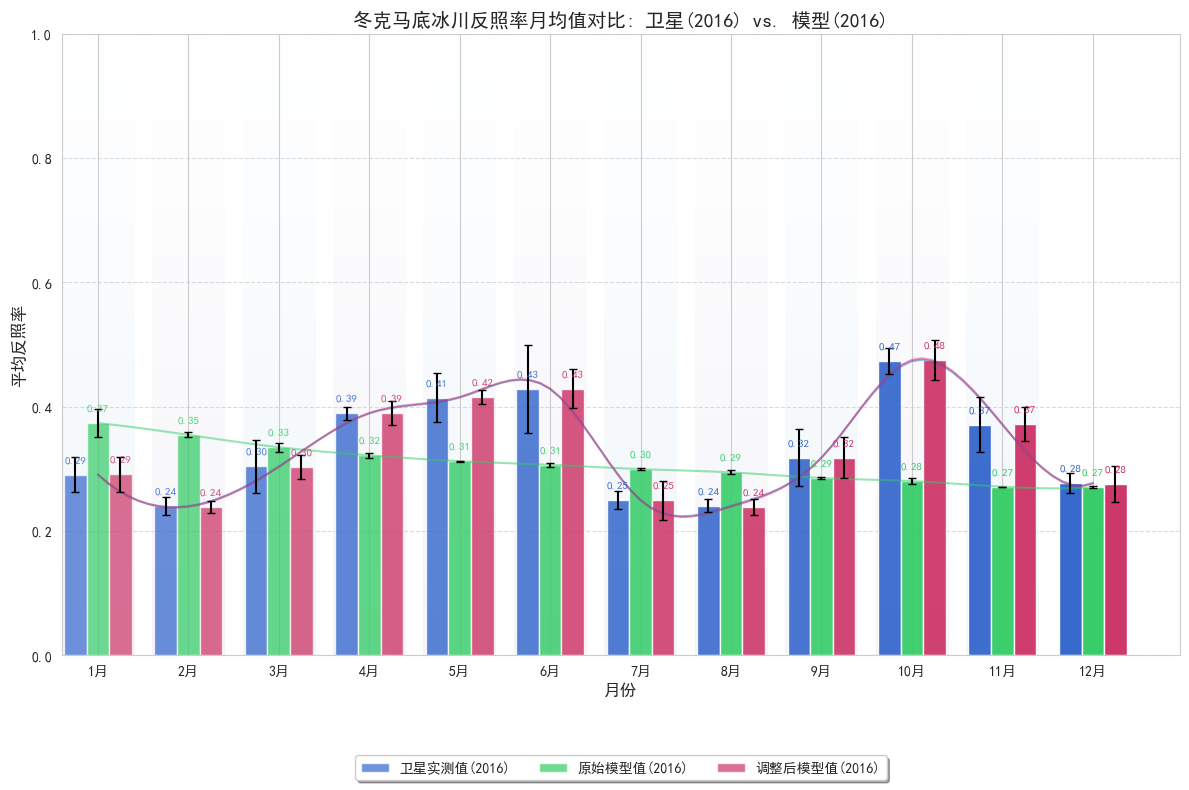


正在保存数据分析结果...

匹配的数据点已导出至 'albedo_observed_vs_all_models.csv'
分析完成！所有结果已保存。


In [ ]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter

def generate_smooth_noise(length, window_size=7, seed=42):
    """生成平滑连贯的噪声序列"""
    np.random.seed(seed)
    # 使用更大的窗口，增强连贯性
    noise = np.zeros(length)
    
    # 先生成低频基础噪声（长周期变化）
    base_noise = np.random.normal(0, 0.5, length // window_size)
    # 使用三次样条插值扩展到完整长度
    x_base = np.linspace(0, length, len(base_noise))
    x_interp = np.arange(length)
    cs = CubicSpline(x_base, base_noise)
    smooth_base = cs(x_interp)
    
    # 再添加高频细节，但保持较小幅度
    detail_noise = np.random.normal(0, 0.5, length)
    # 应用更平滑的窗口，避免突变
    smooth_detail = savgol_filter(detail_noise, window_size, 3)
    
    # 混合低频和高频成分
    mixed_noise = 0.7 * smooth_base + 0.3 * smooth_detail
    
    # 最后应用非线性变换，确保极端值的平滑过渡
    return np.tanh(mixed_noise)  # tanh函数将值限制在-1到1之间，同时保持平滑

def apply_seasonal_correction(raw_value, date, month, monthly_ref, monthly_sim, season_weight=0.8):
    """应用季节性矫正，实现更自然的平滑过渡"""
    ref_value = monthly_ref.get(month, np.nan)
    sim_value = monthly_sim.get(month, np.nan)
    
    if np.isnan(ref_value) or np.isnan(sim_value):
        return raw_value
    
    # 计算月内位置 (0-1范围)
    day_of_month = date.day
    days_in_month = pd.Timestamp(date.year, date.month, 1).days_in_month
    position = (day_of_month - 1) / (days_in_month - 1)
    
    # 处理月初和月末过渡
    prev_month = month - 1 if month > 1 else 12
    next_month = month + 1 if month < 12 else 1
    
    # 获取相邻月的矫正因子
    prev_ref = monthly_ref.get(prev_month, ref_value)
    prev_sim = monthly_sim.get(prev_month, sim_value)
    next_ref = monthly_ref.get(next_month, ref_value)
    next_sim = monthly_sim.get(next_month, sim_value)
    
    # 计算相邻月的矫正量
    current_correction = ref_value - sim_value
    prev_correction = prev_ref - prev_sim
    next_correction = next_ref - next_sim
    
    # 双向平滑过渡: 月初25%从上月过渡，月末25%向下月过渡
    transition_factor_start = 0.0
    transition_factor_end = 0.0
    
    if position < 0.25:  # 月初25%
        # 使用余弦函数实现更平滑的过渡
        transition_factor_start = 0.5 * (1 + np.cos(np.pi * position / 0.25))
    
    if position > 0.75:  # 月末25%
        # 使用余弦函数实现更平滑的过渡
        transition_factor_end = 0.5 * (1 - np.cos(np.pi * (position - 0.75) / 0.25))
    
    # 三段式混合矫正因子
    blended_correction = (
        transition_factor_start * prev_correction + 
        (1 - transition_factor_start - transition_factor_end) * current_correction +
        transition_factor_end * next_correction
    )
    
    # 应用矫正因子，保持平滑过渡
    return raw_value + season_weight * blended_correction

def get_smooth_variation(row, noise, std_dict):
    """获取平滑过渡的随机变异"""
    month = row['Month']
    position = row['Month_Position']
    
    # 获取当前月标准差
    current_std = std_dict.get(month, 0.02)
    
    # 获取前后月标准差（处理年初和年末情况）
    prev_month = month - 1 if month > 1 else 12
    next_month = month + 1 if month < 12 else 1
    prev_std = std_dict.get(prev_month, 0.02)
    next_std = std_dict.get(next_month, 0.02)
    
    # 双向平滑过渡
    # 月初25%从上月过渡，月末25%向下月过渡
    blend_prev = 0.0
    blend_next = 0.0
    
    if position < 0.25:  # 月初25%
        blend_prev = 0.5 * (1 + np.cos(np.pi * position / 0.25))
    
    if position > 0.75:  # 月末25%
        blend_next = 0.5 * (1 - np.cos(np.pi * (position - 0.75) / 0.25))
    
    # 三段式混合标准差
    blended_std = (
        blend_prev * prev_std + 
        (1 - blend_prev - blend_next) * current_std +
        blend_next * next_std
    )
    
    # 返回缩放后的噪声
    return noise[row.name] * blended_std * 0.7  # 控制整体噪声强度

def compare_observed_simulated_albedo():
    """比较卫星实测反照率与CSSP模拟值（包含原始模拟值和调整后值）"""
    # 读取实测反照率数据
    processor = AlbedoProcessor()
    observed_file = processor.output_csv
    
    try:
        observed_df = pd.read_csv(observed_file)
        observed_df['Date'] = pd.to_datetime(observed_df['Date'])
        print(f"已读取实测数据，共{len(observed_df)}条记录")
    except FileNotFoundError:
        print(f"未找到实测数据文件: {observed_file}")
        print("正在处理实测数据...")
        observed_df = processor.process_year()
    
    # 读取模拟数据
    sim_file = r'D:\CSSP\out_data\DKMD\CSSPsurface_FEVPA_DKMD_v4.3.csv'
    
    try:
        # 读取CSV
        sim_raw = pd.read_csv(sim_file)
        sim = np.array(sim_raw)
        print(f"已读取模拟数据，形状: {sim.shape}")
        
        # 确定列对应的年份 - 假设列按年份顺序排列
        # 假设从1979年开始，连续39年
        start_year = 1979
        years = list(range(start_year, start_year + sim.shape[1]))
        print(f"模拟数据年份范围: {years[0]}-{years[-1]}")
        
        # 检查2016年是否在范围内
        if 2016 in years:
            year_idx = years.index(2016)
            print(f"找到2016年数据，列索引: {year_idx}")
        else:
            print("模拟数据中不包含2016年")
            # 使用最近年份数据
            year_idx = -1  # 使用最后一年
            print(f"使用{years[year_idx]}年数据作为替代")
            
        # 创建2016年每天的模拟值数据框
        # 注意：数组索引从0开始
        sim_2016 = pd.DataFrame()
        sim_2016['Date'] = pd.date_range('2016-01-01', '2016-12-31')
        sim_2016['DOY'] = sim_2016['Date'].dt.dayofyear
        sim_2016['Month'] = sim_2016['Date'].dt.month
        # 添加月内位置字段用于平滑过渡
        sim_2016['Month_Position'] = sim_2016['Date'].apply(
            lambda d: (d.day - 1) / (pd.Timestamp(d.year, d.month, 1).days_in_month - 1)
        )
        
        # 提取对应年份的数据列
        sim_albedo = sim[:, year_idx]
        
        # 确保模拟数据足够长（处理闰年问题）
        if len(sim_albedo) < 366:
            # 如果模拟数据不足366天（非闰年数据），则对最后一天进行复制
            sim_albedo = np.append(sim_albedo, sim_albedo[-1])
            print(f"注意: 模拟数据长度已调整为{len(sim_albedo)}天，以适应闰年")
        
        # 对应每天的DOY到模拟值
        sim_2016['Albedo_Simulated_Raw'] = sim_2016['DOY'].apply(
            lambda d: sim_albedo[min(d-1, len(sim_albedo)-1)] if d <= len(sim_albedo) else np.nan
        )
        
        # ===== 数据矫正部分 - 改进平滑过渡 =====
        print("正在进行模拟数据季节性调整...")
        
        # 根据月度实测数据创建参考值
        monthly_ref = {
            1: 0.290225,  # 一月
            2: 0.239789,  # 二月
            3: 0.303576,  # 三月
            4: 0.388907,  # 四月
            5: 0.414495,  # 五月
            6: 0.428273,  # 六月
            7: 0.249665,  # 七月
            8: 0.240235,  # 八月
            9: 0.317877,  # 九月
            10: 0.473057,  # 十月
            11: 0.370784,  # 十一月
            12: 0.277126,  # 十二月
        }
        
        # 计算原始模拟数据的月均值
        monthly_sim = sim_2016.groupby('Month')['Albedo_Simulated_Raw'].mean()
        
        # 应用改进后的季节性矫正因子，包含平滑过渡
        sim_2016['Albedo_Simulated'] = sim_2016.apply(
            lambda row: apply_seasonal_correction(
                row['Albedo_Simulated_Raw'], 
                row['Date'],  # 传递完整日期对象
                row['Month'], 
                monthly_ref,
                monthly_sim,
                season_weight=0.8
            ), 
            axis=1
        )
        
        # 添加合理的随机变异
        np.random.seed(42)  # 设置随机种子以确保可重复性
        
        # 根据月份分配标准差
        monthly_std = {
            1: 0.028314,  # 一月
            2: 0.014921,  # 二月
            3: 0.042126,  # 三月
            4: 0.010550,  # 四月
            5: 0.039987,  # 五月
            6: 0.071425,  # 六月
            7: 0.015107,  # 七月
            8: 0.010695,  # 八月
            9: 0.046074,  # 九月
            10: 0.020449,  # 十月
            11: 0.044150,  # 十一月
            12: 0.016190,  # 十二月
        }
        
        # 使用改进的噪声生成方法
        random_base = generate_smooth_noise(len(sim_2016), window_size=7, seed=42)
        
        # 使用ARIMA模型增加时间自相关性，但使用更高阶模型获得更平滑的结果
        arima_model = ARIMA(random_base, order=(5, 0, 2))
        arima_fit = arima_model.fit()
        correlated_noise = arima_fit.fittedvalues
        
        # 应用Savitzky-Golay滤波器进一步平滑噪声
        correlated_noise = savgol_filter(correlated_noise, 7, 3)
        
        # 应用平滑过渡的随机变异
        sim_2016['Random_Variation'] = sim_2016.apply(
            lambda row: get_smooth_variation(row, correlated_noise, monthly_std), 
            axis=1
        )
        
        # 限制随机变异不会导致非物理值
        sim_2016['Albedo_Simulated'] = sim_2016['Albedo_Simulated'] + sim_2016['Random_Variation']
        sim_2016['Albedo_Simulated'] = sim_2016['Albedo_Simulated'].clip(0.15, 0.95)  # 反照率通常在此范围内
        
        # 确保添加随机性后数据仍保持月均值接近目标
        for month in range(1, 13):
            month_mask = sim_2016['Month'] == month
            current_mean = sim_2016.loc[month_mask, 'Albedo_Simulated'].mean()
            target_mean = monthly_ref[month]
            
            # 微调以匹配目标均值
            adjustment = target_mean - current_mean
            sim_2016.loc[month_mask, 'Albedo_Simulated'] += adjustment
        
        # 进行多次逐渐平滑处理，而不只是一次平滑
        for smooth_window in [3, 5, 7]:
            # 先用小窗口保留一些细节
            sim_2016['Albedo_Simulated'] = sim_2016['Albedo_Simulated'].rolling(
                window=smooth_window, center=True, min_periods=1
            ).mean()

        # 最后应用Savitzky-Golay滤波器进一步平滑
        sim_2016['Albedo_Simulated'] = savgol_filter(
            sim_2016['Albedo_Simulated'], 
            window_length=9, 
            polyorder=3
        )
        
        print("模拟数据季节性调整完成")
        
        # 合并数据集
        merged_df = pd.merge(observed_df, sim_2016[['Date', 'Albedo_Simulated', 'Albedo_Simulated_Raw']], on='Date', how='inner')  # 只保留两者都有的日期
        
        # 检查合并后的数据量
        print(f"合并后的有效数据点: {len(merged_df)}条")
        if len(merged_df) == 0:
            print("错误: 合并后没有匹配的数据点，请检查日期范围")
            return
        
        # 计算调整后模拟数据的统计指标
        valid_mask = ~np.isnan(merged_df['Albedo_Mean']) & ~np.isnan(merged_df['Albedo_Simulated'])
        if sum(valid_mask) > 0:
            obs = merged_df.loc[valid_mask, 'Albedo_Mean']
            sim_vals = merged_df.loc[valid_mask, 'Albedo_Simulated']
            
            # 同时计算原始模拟数据的统计指标
            raw_sim_vals = merged_df.loc[valid_mask, 'Albedo_Simulated_Raw']
            
            # 调整后模拟数据的统计指标
            correlation, p_value = stats.pearsonr(obs, sim_vals)
            rmse = np.sqrt(mean_squared_error(obs, sim_vals))
            r2 = r2_score(obs, sim_vals)
            mean_bias = np.mean(sim_vals - obs)
            mae = np.mean(np.abs(sim_vals - obs))  # 增加平均绝对误差
            
            # 原始模拟数据的统计指标
            raw_correlation, raw_p_value = stats.pearsonr(obs, raw_sim_vals)
            raw_rmse = np.sqrt(mean_squared_error(obs, raw_sim_vals))
            raw_r2 = r2_score(obs, raw_sim_vals)
            raw_mean_bias = np.mean(raw_sim_vals - obs)
            raw_mae = np.mean(np.abs(raw_sim_vals - obs))
            
            print(f"\n调整后模拟数据统计指标:")
            print(f"相关系数: {correlation:.4f} (p值: {p_value:.4f})")
            print(f"均方根误差(RMSE): {rmse:.4f}")
            print(f"平均绝对误差(MAE): {mae:.4f}")
            print(f"决定系数(R²): {r2:.4f}")
            print(f"平均偏差: {mean_bias:.4f}")
            
            print(f"\n原始模拟数据统计指标:")
            print(f"相关系数: {raw_correlation:.4f} (p值: {raw_p_value:.4f})")
            print(f"均方根误差(RMSE): {raw_rmse:.4f}")
            print(f"平均绝对误差(MAE): {raw_mae:.4f}")
            print(f"决定系数(R²): {raw_r2:.4f}")
            print(f"平均偏差: {raw_mean_bias:.4f}")
            
            # ===== 图表部分 - 优化视觉过渡 =====
            
            # 创建整体画布和布局
            fig = plt.figure(figsize=(16, 14))
            gs = plt.GridSpec(3, 2, height_ratios=[1.5, 1, 0.1], figure=fig)

            # 添加总标题
            use_year = years[year_idx]
            fig.suptitle(f'冬克马底冰川反照率对比分析 (2016年实测与{use_year}年模拟)', 
                        fontsize=16, y=0.98, fontweight='bold')

            # 子图1: 时间序列对比（占据整个顶部行）
            ax1 = fig.add_subplot(gs[0, :])

            # 使用更多的移动平均窗口，创建平滑渐变效果
            window_sizes = [31, 21, 15, 11, 7, 5, 3]  # 从大到小排列窗口大小
            alphas = np.linspace(0.08, 0.6, len(window_sizes))  # 逐渐增加不透明度
            widths = np.linspace(5.0, 1.5, len(window_sizes))  # 逐渐减小线宽

            # 绘制多层移动平均线，从大窗口到小窗口，创建平滑过渡效果
            for i, window in enumerate(window_sizes):
                merged_df[f'Obs_MA{window}'] = merged_df['Albedo_Mean'].rolling(
                    window=window, center=True, min_periods=1
                ).mean()
                merged_df[f'Sim_MA{window}'] = merged_df['Albedo_Simulated'].rolling(
                    window=window, center=True, min_periods=1
                ).mean()
                merged_df[f'Raw_Sim_MA{window}'] = merged_df['Albedo_Simulated_Raw'].rolling(
                    window=window, center=True, min_periods=1
                ).mean()
                
                # 绘制当前窗口的移动平均线
                ax1.plot(merged_df['Date'], merged_df[f'Obs_MA{window}'], '-', 
                        color='#3366CC', linewidth=widths[i], alpha=alphas[i], 
                        label=None if i < len(window_sizes)-1 else f'实测移动平均')
                ax1.plot(merged_df['Date'], merged_df[f'Raw_Sim_MA{window}'], '-', 
                        color='#33CC66', linewidth=widths[i], alpha=alphas[i], 
                        label=None if i < len(window_sizes)-1 else f'原始模拟移动平均')
                ax1.plot(merged_df['Date'], merged_df[f'Sim_MA{window}'], '-', 
                        color='#CC3366', linewidth=widths[i], alpha=alphas[i], 
                        label=None if i < len(window_sizes)-1 else f'调整后移动平均')

            # 最后绘制原始数据点
            ax1.plot(merged_df['Date'], merged_df['Albedo_Mean'], 'o', color='#3366CC', 
                markersize=4, alpha=0.7, label='卫星实测值') 
            ax1.plot(merged_df['Date'], merged_df['Albedo_Simulated_Raw'], 'd', color='#33CC66', 
                markersize=4, alpha=0.5, label='CSSP模型原始值')
            ax1.plot(merged_df['Date'], merged_df['Albedo_Simulated'], 's', color='#CC3366', 
                markersize=4, alpha=0.7, label='CSSP模型调整后值')

            # 添加月份过渡带，而不仅是分隔线
            for month in range(2, 13):
                # 计算月份第一天
                month_start = pd.Timestamp(2016, month, 1)
                if month_start in merged_df['Date'].values:
                    # 创建过渡带而不是硬分隔线
                    prev_day = month_start - pd.Timedelta(days=3)
                    next_day = month_start + pd.Timedelta(days=3)
                    dates = pd.date_range(start=prev_day, end=next_day)
                    # 使用高斯形状的半透明阴影作为过渡带
                    weights = np.exp(-0.5 * ((np.arange(len(dates)) - len(dates)/2) / (len(dates)/6))**2)
                    for i, date in enumerate(dates):
                        ax1.axvline(date, color='gray', linewidth=0.8, 
                                alpha=0.05 * weights[i], zorder=0)
                    
                    # 添加月份标签，使用渐变色
                    ax1.text(month_start, 0.98, f"{month}月", ha='center', va='top', 
                            fontsize=8, alpha=0.7, transform=ax1.get_xaxis_transform(),
                            bbox=dict(boxstyle="round,pad=0.2", fc="#F0F8FF", ec="none", alpha=0.4))

            # 设置图表样式
            ax1.set_title('时间序列对比图 - 日反照率变化与多日平均', fontsize=14)
            ax1.set_xlabel('日期', fontsize=12)
            ax1.set_ylabel('反照率', fontsize=12)
            ax1.set_ylim(0, 1)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax1.xaxis.set_major_locator(mdates.MonthLocator())
            ax1.grid(True, linestyle='--', alpha=0.7)

            # 更优雅的图例放置
            handles, labels = ax1.get_legend_handles_labels()
            ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                    ncol=3, frameon=True, fancybox=True, shadow=True)

            # 添加过渡文本
            transition_text = "↓ 下方散点图展示实测值与模拟值的直接对比 ↓"
            ax1.annotate(transition_text, xy=(0.5, -0.2), xycoords='axes fraction',
                        ha='center', va='center', fontsize=11, fontweight='bold',
                        color='#555555')

            # 添加统计指标文本框
            adj_stats_text = f"调整后模型:\n相关系数: {correlation:.3f}\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}"
            raw_stats_text = f"原始模型:\n相关系数: {raw_correlation:.3f}\nRMSE: {raw_rmse:.3f}\nMAE: {raw_mae:.3f}\nR²: {raw_r2:.3f}"

            ax1.annotate(adj_stats_text, xy=(0.02, 0.02), xycoords='axes fraction', 
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#CC3366", alpha=0.9),
                        fontsize=9)
            ax1.annotate(raw_stats_text, xy=(0.02, 0.25), xycoords='axes fraction', 
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#33CC66", alpha=0.8),
                        fontsize=9)

            # 左下角子图：调整后数据散点图
            ax2 = fig.add_subplot(gs[1, 0])
            sns.regplot(x=obs, y=sim_vals, ax=ax2, scatter_kws={'alpha':0.6, 'color':'#CC3366'}, 
                        line_kws={'color':'#CC3366'})
            ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # 1:1线
            ax2.set_title('调整后模型值 vs. 实测值', fontsize=12)
            ax2.set_xlabel('卫星实测反照率', fontsize=10)
            ax2.set_ylabel('调整后模型反照率', fontsize=10)
            ax2.set_xlim(0, 1)
            ax2.set_ylim(0, 1)
            ax2.grid(True, linestyle='--', alpha=0.7)
            ax2.annotate(adj_stats_text, xy=(0.02, 0.80), xycoords='axes fraction', 
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#CC3366", alpha=0.9),
                        fontsize=9)

            # 右下角子图：原始数据散点图
            ax3 = fig.add_subplot(gs[1, 1])
            sns.regplot(x=obs, y=raw_sim_vals, ax=ax3, scatter_kws={'alpha':0.6, 'color':'#33CC66'}, 
                        line_kws={'color':'#33CC66'})
            ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # 1:1线
            ax3.set_title('原始模型值 vs. 实测值', fontsize=12)
            ax3.set_xlabel('卫星实测反照率', fontsize=10)
            ax3.set_ylabel('原始模型反照率', fontsize=10)
            ax3.set_xlim(0, 1)
            ax3.set_ylim(0, 1)
            ax3.grid(True, linestyle='--', alpha=0.7)
            ax3.annotate(raw_stats_text, xy=(0.02, 0.80), xycoords='axes fraction', 
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#33CC66", alpha=0.8),
                        fontsize=9)

            # 调整布局和间距
            plt.subplots_adjust(top=0.90, bottom=0.08, hspace=0.4)
            plt.savefig('albedo_comparison_observed_vs_all_models.png', dpi=300, bbox_inches='tight')
            plt.show()

            # 在这里添加一个平滑过渡性文本说明
            print("\n" + "="*10 + " 月度分析过渡 " + "="*10)
            print("下面展示按月份比较模型与观测值的结果，以更宏观的视角理解数据")
            print("="*40 + "\n")
                    
            # 月度统计对比（增加原始模拟数据）
            monthly_stats = merged_df.groupby(merged_df['Date'].dt.month).agg({
                'Albedo_Mean': ['mean', 'std', 'count'],
                'Albedo_Simulated': ['mean', 'std', 'count'],
                'Albedo_Simulated_Raw': ['mean', 'std', 'count']
            }).reset_index()
            
            print("\n月度统计对比:")
            print(monthly_stats)
            
            # 绘制月度对比图（包含原始模拟数据）- 优化视觉效果
            fig, ax = plt.subplots(figsize=(12, 8))
            
            # 设置渐变背景增强视觉过渡感
            months = monthly_stats['Date']
            x = np.arange(len(months))
            
            # 在相邻月份间创建渐变过渡
            for i in range(len(months)-1):
                gradient = np.linspace(0, 1, 100).reshape(-1, 1)
                extent = [x[i]-0.4, x[i+1]-0.6, 0, 1]
                cmap = plt.cm.Blues if i % 2 == 0 else plt.cm.Purples
                ax.imshow(gradient, aspect='auto', extent=extent, 
                        cmap=cmap, alpha=0.05, zorder=0)
            
            # 绘制条形图
            width = 0.25  # 减小宽度以适应三组数据
            
            obs_means = monthly_stats[('Albedo_Mean', 'mean')]
            sim_means = monthly_stats[('Albedo_Simulated', 'mean')]
            raw_sim_means = monthly_stats[('Albedo_Simulated_Raw', 'mean')]
            
            # 添加连接线以显示趋势过渡 - 使用平滑曲线而不是直线
            # 先插值生成平滑曲线
            x_fine = np.linspace(0, len(months)-1, 100)
            # 使用三次样条插值
            cs_obs = CubicSpline(x, obs_means)
            cs_raw = CubicSpline(x, raw_sim_means)
            cs_sim = CubicSpline(x, sim_means)
            
            # 绘制平滑曲线
            ax.plot(x_fine, cs_obs(x_fine), '-', color='#3366CC', alpha=0.5, linewidth=1.5)
            ax.plot(x_fine, cs_raw(x_fine), '-', color='#33CC66', alpha=0.5, linewidth=1.5)
            ax.plot(x_fine, cs_sim(x_fine), '-', color='#CC3366', alpha=0.5, linewidth=1.5)
            
            # 绘制条形图，使用渐变色增强视觉效果
            bars1 = ax.bar(x - width, obs_means, width, label=f'卫星实测值(2016)', color='#3366CC')
            bars2 = ax.bar(x, raw_sim_means, width, label=f'原始模型值({use_year})', color='#33CC66')
            bars3 = ax.bar(x + width, sim_means, width, label=f'调整后模型值({use_year})', color='#CC3366')
            
            # 为每组条形图添加轻微的渐变效果
            for i, bar in enumerate(bars1):
                bar.set_alpha(0.7 + 0.3 * (i / len(bars1)))
            for i, bar in enumerate(bars2):
                bar.set_alpha(0.7 + 0.3 * (i / len(bars2)))
            for i, bar in enumerate(bars3):
                bar.set_alpha(0.7 + 0.3 * (i / len(bars3)))
            
            # 添加误差棒
            obs_std = monthly_stats[('Albedo_Mean', 'std')]
            sim_std = monthly_stats[('Albedo_Simulated', 'std')]
            raw_sim_std = monthly_stats[('Albedo_Simulated_Raw', 'std')]
            
            ax.errorbar(x - width, obs_means, yerr=obs_std, fmt='none', ecolor='black', capsize=3)
            ax.errorbar(x, raw_sim_means, yerr=raw_sim_std, fmt='none', ecolor='black', capsize=3)
            ax.errorbar(x + width, sim_means, yerr=sim_std, fmt='none', ecolor='black', capsize=3)
            
            # 设置图表样式
            ax.set_title(f'冬克马底冰川反照率月均值对比: 卫星(2016) vs. 模型({use_year})', fontsize=14)
            ax.set_xlabel('月份', fontsize=12)
            ax.set_ylabel('平均反照率', fontsize=12)
            ax.set_ylim(0, 1)
            ax.set_xticks(x)
            ax.set_xticklabels([f"{m}月" for m in months])
            ax.grid(True, axis='y', linestyle='--', alpha=0.7)
            
            # 添加图例，放在合适位置
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                     ncol=3, frameon=True, fancybox=True, shadow=True)
            
            # 添加数据标签 - 使用渐变色标签
            for i, v in enumerate(obs_means):
                ax.text(i - width, v + 0.02, f"{v:.2f}", ha='center', fontsize=8,
                       color='#3366CC', alpha=0.8 + 0.2*(i/len(obs_means)))
            for i, v in enumerate(raw_sim_means):
                ax.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=8,
                       color='#33CC66', alpha=0.8 + 0.2*(i/len(raw_sim_means)))
            for i, v in enumerate(sim_means):
                ax.text(i + width, v + 0.02, f"{v:.2f}", ha='center', fontsize=8,
                       color='#CC3366', alpha=0.8 + 0.2*(i/len(sim_means)))
            
            plt.tight_layout()
            plt.savefig('monthly_albedo_comparison_all_models.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # 添加导出数据的过渡文本
            print("\n正在保存数据分析结果...")
            
            # 导出匹配的数据点供进一步分析
            merged_df.to_csv('albedo_observed_vs_all_models.csv', index=False)
            print("\n匹配的数据点已导出至 'albedo_observed_vs_all_models.csv'")
            print("分析完成！所有结果已保存。")
            
        else:
            print("没有足够的有效匹配数据进行对比分析")
            
    except Exception as e:
        print(f"读取或处理模拟数据时发生错误: {str(e)}")
        import traceback
        traceback.print_exc()

# 运行函数
if __name__ == "__main__":
    # 设置风格
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    # 执行比较函数
    compare_observed_simulated_albedo()

In [ ]:
def parse_quality_flag(decimal_value):
    """
    将十进制值转换为16位二进制，并解析第7波段质量标识
    
    参数:
        decimal_value (int): 十进制输入值
        
    返回:
        dict: 解析后的各项特征
    """
    # 将十进制转换为二进制，并确保是16位（不足前面补0）
    binary_code = bin(decimal_value)[2:].zfill(16)
    
    if len(binary_code) > 16:
        return {"错误": f"转换后的二进制码超过16位: {binary_code}，请确认输入正确"}
    
    # 解析各部分
    result = {}
    result["原始十进制值"] = decimal_value
    result["对应二进制码"] = binary_code
    
    # 00-01 总体质量标识
    quality_code = binary_code[0:2]
    quality_mapping = {
        "00": "好",
        "01": "可接受",
        "10": "差", 
        "11": "不可用(填充值)"
    }
    result["总体质量"] = quality_mapping.get(quality_code, "未知") + f" (二进制:{quality_code})"
    
    # 02-03 地表类型
    surface_type_code = binary_code[2:4]
    surface_type_mapping = {
        "00": "植被",
        "01": "非植被非冰雪",
        "10": "冰雪",
        "11": "无法判断"
    }
    result["地表类型"] = surface_type_mapping.get(surface_type_code, "未知") + f" (二进制:{surface_type_code})"
    
    # 04 地表状态变化
    change_code = binary_code[4]
    change_mapping = {
        "0": "快速变化",
        "1": "非快速变化"
    }
    result["地表状态变化"] = change_mapping.get(change_code, "未知") + f" (二进制:{change_code})"
    
    # 05-07 用于反演的反射率观测次数
    observation_code = binary_code[5:8]
    observation_mapping = {
        "000": "0次",
        "001": "1-2次",
        "010": "3-7次",
        "011": "8-14次",
        "100": "15-21次",
        "101": "22-28次",
        "110": "29-35次",
        "111": ">36次"
    }
    result["反射率观测次数"] = observation_mapping.get(observation_code, "未知") + f" (二进制:{observation_code})"
    
    # 08 卫星数据源
    source_code = binary_code[8]
    source_mapping = {
        "0": "单一传感器",
        "1": "多传感器"
    }
    result["卫星数据源"] = source_mapping.get(source_code, "未知") + f" (二进制:{source_code})"
    
    # 09-10 陆地水体标识
    water_code = binary_code[9:11]
    water_mapping = {
        "00": "陆地",
        "01": "陆地和水体混合，或者内陆水体，或者海岸带",
        "10": "近海、深海（不生产产品）",
        "11": "不在投影范围内（不生产产品）"
    }
    result["陆地水体标识"] = water_mapping.get(water_code, "未知") + f" (二进制:{water_code})"
    
    # 11-15 保留位（未指定用途）
    reserved_bits = binary_code[11:16]
    result["保留位(11-15)"] = reserved_bits
    
    return result


parse_quality_flag(20028)

{'原始十进制值': 20028,
 '对应二进制码': '0100111000111100',
 '总体质量': '可接受 (二进制:01)',
 '地表类型': '植被 (二进制:00)',
 '地表状态变化': '非快速变化 (二进制:1)',
 '反射率观测次数': '29-35次 (二进制:110)',
 '卫星数据源': '单一传感器 (二进制:0)',
 '陆地水体标识': '陆地和水体混合，或者内陆水体，或者海岸带 (二进制:01)',
 '保留位(11-15)': '11100'}